In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.loader import (
    load_interactions,
    load_games,
    load_extended_games,
    load_item_reviews,
    load_user_reviews,
    load_bundles
)

In [2]:
# Load Data
train_interactions = load_interactions(train=True)
test_in = load_interactions(train=False)

games = load_games()
ext_games = load_extended_games()
item_reviews = load_item_reviews()
user_reviews = load_user_reviews()
bundles = load_bundles()

## General Data Quality Checks

- Are there any dataframes we could use for feature engineering?
- Are there any missing values?

In [ ]:
# Quick Overview of DataFrames
dfs = {
    "games": games,
    "extended_games": ext_games,
    "item_reviews": item_reviews,
    "user_reviews": user_reviews,
    "bundles": bundles,
}

for name, df in dfs.items():
    print(f"=== {name} ===")
    print(df.shape)
    print(df.columns)
    print(df.head(3))
    print()

In [ ]:
# Check for Missing Values
for name, df in dfs.items():
    print(f"{name} missing values:")
    # I want to see the missing values amount and the percentage of missing values
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({"missing": missing, "percent": missing_percent})
    display(missing_df[missing_df["missing"] > 0].sort_values(by="percent", ascending=False))
    print()

##### Observations:
- The only useful dfs are 'games' and 'extended_games' for feature engineering.
    - More specifically, 'games.genres', 'games.tags' and 'extended_games.tags_*' columns.
- Others are irrelevant for our research question.

## Questions we need answered now:
- How many users? How many items?
- How many interactions?
- Average interactions per user?
- Distribution of interactions per user? (long tail?)
- Distribution of interactions per item? (popularity bias)

#### We need to know these, because:
- Novelty is affected by how many items a user has interacted with.
- EASE model works better when user has some interactions.
- Understanding popularity bias helps in evaluating recommendation quality.

In [3]:
print("Train Interactions Shape:", train_interactions.shape)
print(train_interactions.head())

# Basic stats
num_users = train_interactions['user_id'].nunique()
num_items = train_interactions['item_id'].nunique()
num_interactions = len(train_interactions)
avg_interactions_per_user = num_interactions / num_users

print(f"Number of Users: {num_users}")
print(f"Number of Items: {num_items}")
print(f"Number of Interactions: {num_interactions}")
print(f"Average Interactions per User: {avg_interactions_per_user:.2f}")

Train Interactions Shape: (2293985, 4)
   user_id  item_id               item_name  playtime
0        0        0          Counter-Strike         6
1        0     2555           Day of Defeat         7
2        0     2556   Day of Defeat: Source      4733
3        0     1043  Counter-Strike: Source      1853
4        0     5335             Psychonauts       333
Number of Users: 54315
Number of Items: 8368
Number of Interactions: 2293985
Average Interactions per User: 42.23


##### Answers:
- Number of Users: 54315
- Number of Items: 8368
- Number of Interactions: 2293985
- Average Interactions per User: 42.25

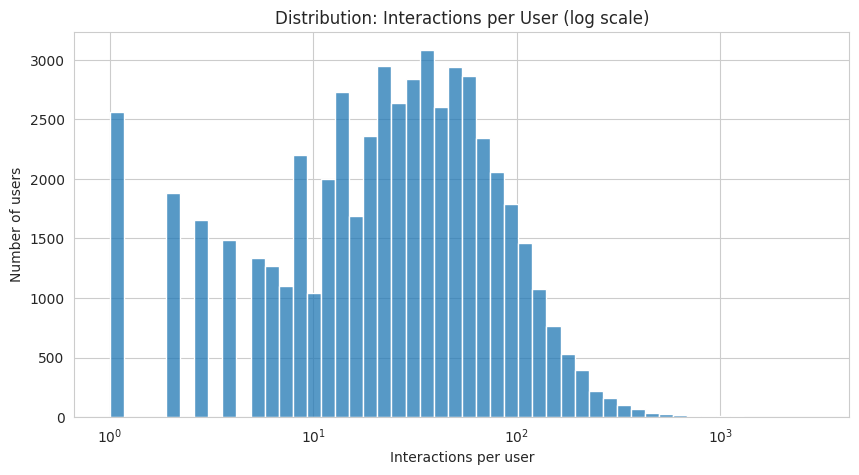

count    54315.000000
mean        42.234834
std         61.378751
min          1.000000
25%         10.000000
50%         26.000000
75%         55.000000
max       2897.000000
Name: count, dtype: float64


In [4]:
user_counts = train_interactions["user_id"].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(user_counts, bins=50, log_scale=True)
plt.title("Distribution: Interactions per User (log scale)")
plt.xlabel("Interactions per user")
plt.ylabel("Number of users")
plt.show()

print(user_counts.describe())

##### Observations on User Interaction Distribution:
- Many users have interactions between 5 and 100.
- A few users have very high interaction counts.

In [ ]:
item_counts = train_interactions["item_id"].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(item_counts, bins=50, log_scale=True, color='purple')
plt.title("Distribution: Interactions per Item (Item Popularity)")
plt.xlabel("Interactions per item")
plt.ylabel("Number of items")
plt.show()

print(item_counts.describe())

##### Observations on Item Interaction Distribution:
- Many items (games) have interactions between 5 and 100, with the median having 20 interactions.
- A tiny fraction of items is extremely popular, with thousands (10k+) of interactions.

## Exploring genres in the games dataset:
- How many genres exist?
- Are they clean?
- Distribution of games across genres?
- Does this potential feature tell me anything about why a user might interact with a game?

#### Why for novelty?
- Different genres may have different popularity dynamics.
- Understanding genre distribution helps in evaluating recommendation diversity.
- Some genres may be more niche, affecting novelty calculations.
- Helps in understanding user preferences and behavior.

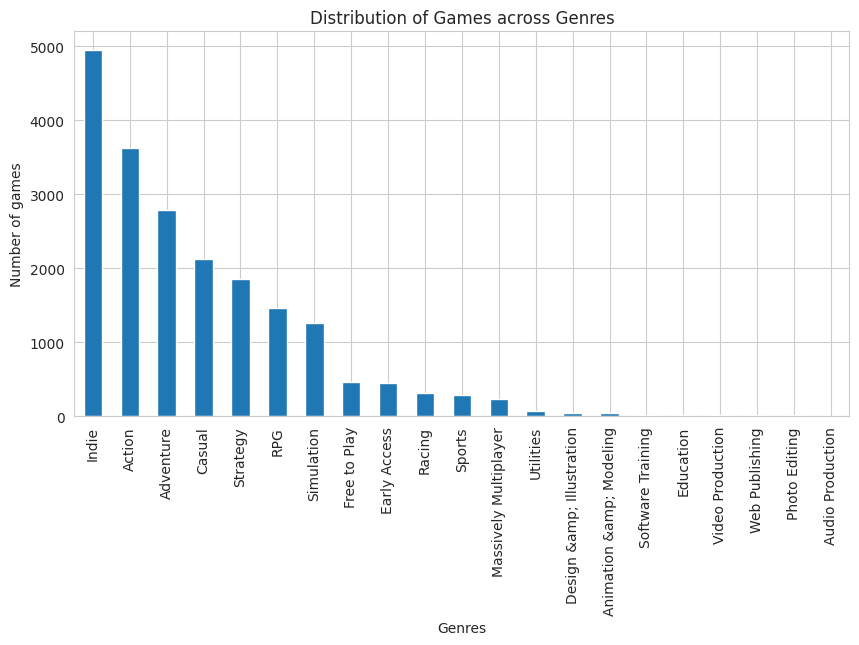

Number of unique genres: 20
Indie        4955
Action       3623
Adventure    2786
Casual       2123
Strategy     1861
Name: count, dtype: int64


In [5]:
# Count occurrences of all genres
import ast

genre_series = games['genres'].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
all_genres = [g for sub in genre_series for g in sub]

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(10,5))
genre_counts.plot(kind='bar')
plt.title("Distribution of Games across Genres")
plt.xlabel("Genres")
plt.ylabel("Number of games")
plt.show()

print("Number of unique genres:", genre_counts.nunique())
print(genre_counts.head())

##### Observations on Genres:
- There are 20 unique genres.
- The genres appear clean with no obvious anomalies.
- Indie, Action, Adventure are the most common genres.
- Genres like Animation & Modeling, Audio Production are very rare.
- Genre could be a useful feature for understanding user preferences and behavior.

## Exploring price in the games dataset:
- Are they clean?
- What is the price distribution of games?
- Are there many free games?
- How does price relate to user interactions?
- Are there outliers in pricing?
- How does price vary across genres?
- Does this potential feature tell me anything about why a user might interact with a game?

In [ ]:
# to help with display, otherwise numpy shows scientific notation
np.set_printoptions(suppress=True)

print(games['price'].unique())

# let's try to convert price to numeric (some prices might be strings like 'Free to Play')
def parse_price(price):
    if isinstance(price, (int, float)):
        return float(price)

    if isinstance(price, str):
        p = price.strip().lower()

        # free categories
        if 'free' in p:
            return 0.0

        # extract numeric portions e.g. "19.99", "$59.99"
        import re
        match = re.search(r"(\d+(\.\d+)?)", p)
        if match:
            return float(match.group(1))

    # fallback
    return np.nan

games['price_numeric'] = games['price'].apply(parse_price)
print(games['price_numeric'].unique())


##### Observations on price:
- It is not clean, the datatype is not a float, there are strings like 'Free to Play'.
- After conversion, we have numeric prices and '0.0' for free games.
- There are some NaN values which need to be handled. (this NaN could be because of pricing like 'Play WARMACHINE: Tactics Demo')

In [ ]:
plt.figure(figsize=(10,5))
clean_prices = games['price_numeric'].dropna()
cutoff = clean_prices.quantile(0.995)
clean_prices = clean_prices[clean_prices <= cutoff]
sns.histplot(clean_prices, bins=40, color='green')
plt.title("Price Distribution of Games (log scale)")
plt.xlabel("Price")
plt.ylabel("Number of games")
plt.show()

print(games['price_numeric'].describe())

# how many are free?
num_free_games = (games['price_numeric'] == 0).sum()
total_games = len(games)
print(f"Number of free games: {num_free_games} out of {total_games} ({(num_free_games/total_games)*100:.2f}%)")

##### Observations on Price Distribution:
- Most games are priced between 0 and 20.
- There are about 591 free games, which is around 7% of the total games.
- There are some high-priced games, but they are outliers.
- The average price is around 9.9, with a median of 7.99.

In [ ]:
# how does price relate to user interactions?
merged = pd.merge(train_interactions, games[['item_id', 'price_numeric']], on='item_id', how='left')
price_interaction_counts = merged.groupby('price_numeric').size()
plt.figure(figsize=(10,5))
price_interaction_counts = price_interaction_counts[price_interaction_counts.index <= cutoff]
sns.lineplot(x=price_interaction_counts.index, y=price_interaction_counts.values)
plt.title("User Interactions vs Game Price")
plt.xlabel("Game Price")
plt.ylabel("Number of Interactions")
plt.show()

##### Observations on Price vs Interactions:
- There are huge spikes in interactions for free games, 5, 10, 15 and 20 price points.
- This suggests that users are more likely to interact with games at these price points.
    - Now is this personal preference or because there are more games available at these price points?

In [ ]:
# Are the spikes in interactions at certain price points due to personal preference or because there are more games available at those price points?
# We will normalize the interaction counts by the number of games available at each price point.
games_per_price = games.groupby("price_numeric")["item_id"].nunique()
interactions_per_price = merged.groupby("price_numeric").size()

avg_interactions_per_game = interactions_per_price / games_per_price

avg_interactions_per_game = avg_interactions_per_game.dropna()

plt.figure(figsize=(10,5))
avg_interactions_per_game = avg_interactions_per_game[avg_interactions_per_game.index <= cutoff]
sns.lineplot(x=avg_interactions_per_game.index, y=avg_interactions_per_game.values)
plt.title("Average Interactions per Game vs Game Price")
plt.xlabel("Game Price")
plt.ylabel("Average Interactions per Game")
plt.show()


In [ ]:
# how does price vary across genres?
genre_price_data = []
for _, row in games.iterrows():
    genres = ast.literal_eval(row['genres']) if pd.notnull(row['genres']) else []
    price = row['price_numeric']
    for genre in genres:
        genre_price_data.append((genre, price))
genre_price_df = pd.DataFrame(genre_price_data, columns=['genre', 'price_numeric'])
plt.figure(figsize=(12,6))
sns.boxplot(x='genre', y='price_numeric', data=genre_price_df)
plt.yscale('log')
plt.title("Price Distribution across Genres")
plt.xlabel("Genre")
plt.ylabel("Price (log scale)")
plt.xticks(rotation=90)
plt.show()

##### Price as a feature ?
- I don't see a good reason why price would affect novelty directly.
- Two completely different games could be priced the same, so price alone doesn't indicate similarity or novelty.
- And knowing the price won't tell use anything more because most of the games are clustered in the lower price range. (more specifically between 0 and 20)